Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1321 entries, 0 to 1320
Columns: 5018 entries, link to zoo
dtypes: datetime64[ns](1), float64(5005), int64(6), object(6)
memory usage: 50.6+ MB
None

Class Distribution:
stock_trend
1    0.529145
0    0.470855
Name: proportion, dtype: float64


C:\Users\hp\AppData\Local\Temp\ipykernel_8944\891163137.py:44: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method='ffill') # Forward fill



Feature set shape after engineering: (1321, 22)

Sample of engineered features:
   sentiment_score  text_length  word_count  day_of_week  month  Close_^GSPC  \
0          -0.5267          162          26            0      1  3700.649902   
1           0.5859          199          27            0      1  3700.649902   
2           0.1280          155          21            0      1  3700.649902   
3           0.1280          184          30            0      1  3700.649902   
4          -0.6369          154          24            1      1  3726.860107   

    High_^GSPC    Low_^GSPC   Open_^GSPC  Volume_^GSPC  ...  Close_lag_1  \
0  3769.989990  3662.709961  3764.610107    5015000000  ...     0.000000   
1  3769.989990  3662.709961  3764.610107    5015000000  ...  3700.649902   
2  3769.989990  3662.709961  3764.610107    5015000000  ...  3700.649902   
3  3769.989990  3662.709961  3764.610107    5015000000  ...  3700.649902   
4  3737.830078  3695.070068  3698.020020    4591020000  ..

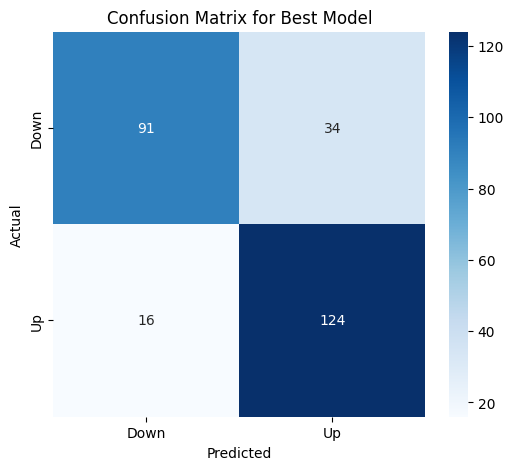


--- Feature Importances ---
                  Feature  Importance
11           daily_return    0.221320
12            Close_lag_1    0.060304
8              Open_^GSPC    0.059572
5             Close_^GSPC    0.059320
6              High_^GSPC    0.057221
10            price_range    0.047738
14            Close_lag_3    0.047490
9            Volume_^GSPC    0.045739
21            Close_Std_5    0.041810
7               Low_^GSPC    0.041114
3             day_of_week    0.037010
4                   month    0.036893
19            Volume_MA_5    0.032267
20         sentiment_MA_5    0.028272
16  sentiment_score_lag_2    0.026935
13            Close_lag_2    0.026858
0         sentiment_score    0.024734
1             text_length    0.023970
15  sentiment_score_lag_1    0.021746
18             Close_MA_5    0.021662
17  sentiment_score_lag_3    0.020430
2              word_count    0.017597


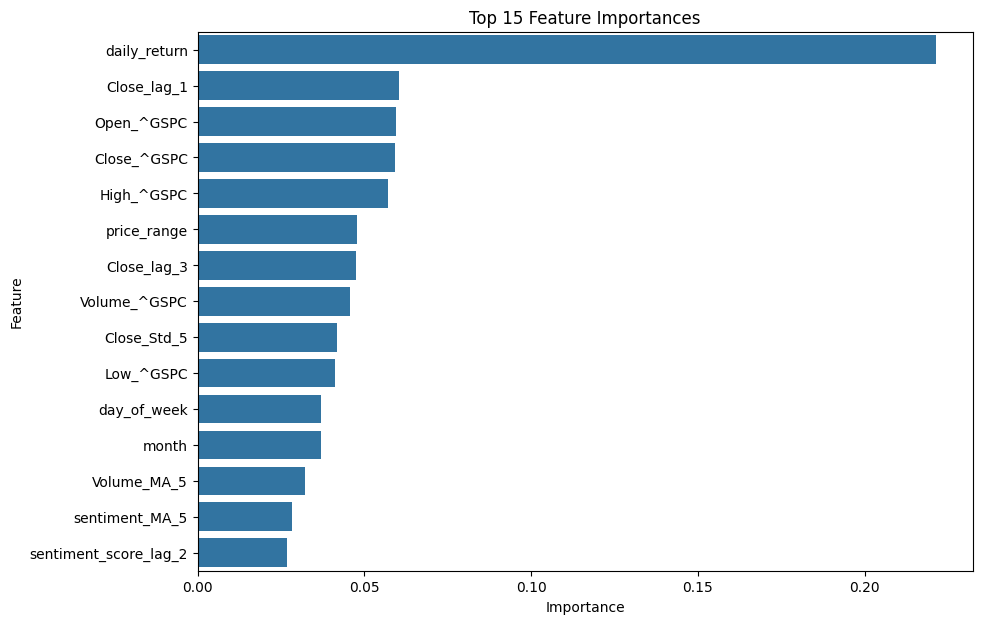


--- Baseline Model (Majority Class Prediction) ---
Baseline Accuracy: 0.5283


In [4]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit # Import TimeSeriesSplit
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

# Suppress XGBoost warnings
warnings.filterwarnings('ignore', category=UserWarning)

# Load and preprocess data
data = pd.read_csv('stock(updated).csv')
data = data.dropna()
data['date'] = pd.to_datetime(data['date']) # Convert 'date' to datetime objects
data = data.sort_values('date').reset_index(drop=True) # Sort by date and reset index

# Display basic information
print("Dataset Info:")
print(data.info())
print("\nClass Distribution:")
print(data['stock_trend'].value_counts(normalize=True))

# --- Feature Engineering ---
# Adding more sophisticated features based on stock prices
data['price_range'] = data['High_^GSPC'] - data['Low_^GSPC']
data['daily_return'] = data['Close_^GSPC'].pct_change()

# Lagged features for stock prices and sentiment
for lag in range(1, 4): # Lag 1, 2, 3
    data[f'Close_lag_{lag}'] = data['Close_^GSPC'].shift(lag)
    data[f'sentiment_score_lag_{lag}'] = data['sentiment_score'].shift(lag)

# Rolling window features (e.g., moving averages, standard deviation)
data['Close_MA_5'] = data['Close_^GSPC'].rolling(window=5).mean()
data['Volume_MA_5'] = data['Volume_^GSPC'].rolling(window=5).mean()
data['sentiment_MA_5'] = data['sentiment_score'].rolling(window=5).mean()
data['Close_Std_5'] = data['Close_^GSPC'].rolling(window=5).std()

# Fill NaN values created by lagging and rolling features (e.g., with forward fill or mean)
# It's crucial to handle NaNs AFTER creating lagged/rolling features.
# For time series, forward fill is often appropriate, or drop rows if it's acceptable to lose early data.
data = data.fillna(method='ffill') # Forward fill
data = data.fillna(0) # Fill any remaining NaNs (e.g., if first few rows were NaN due to shift/rolling)

# --- Select Features and Target ---
# Update features list to include engineered features
features = [
    'sentiment_score', 'text_length', 'word_count', 'day_of_week', 'month',
    'Close_^GSPC', 'High_^GSPC', 'Low_^GSPC', 'Open_^GSPC', 'Volume_^GSPC',
    'price_range', 'daily_return',
    'Close_lag_1', 'Close_lag_2', 'Close_lag_3',
    'sentiment_score_lag_1', 'sentiment_score_lag_2', 'sentiment_score_lag_3',
    'Close_MA_5', 'Volume_MA_5', 'sentiment_MA_5', 'Close_Std_5'
]

X = data[features]
y = data['stock_trend']

print(f"\nFeature set shape after engineering: {X.shape}")
print("\nSample of engineered features:")
print(X.head())

# --- Time Series Split ---
# Use TimeSeriesSplit for appropriate cross-validation in time series data
# n_splits determines the number of splits. For example, 5 splits means 5 train-test pairs.
tscv = TimeSeriesSplit(n_splits=5)

# --- Hyperparameter Tuning with GridSearchCV ---
# Define the parameter grid to search
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of boosting rounds
    'learning_rate': [0.01, 0.05, 0.1],  # Step size shrinkage
    'max_depth': [3, 5, 7],  # Maximum depth of a tree
    'subsample': [0.7, 0.9],  # Subsample ratio of the training instance
    'colsample_bytree': [0.7, 0.9], # Subsample ratio of columns when constructing each tree
    'gamma': [0, 0.1, 0.2], # Minimum loss reduction required to make a further partition on a leaf node
    'min_child_weight': [1, 3] # Minimum sum of instance weight (hessian) needed in a child
}

# Initialize XGBoost model
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Set up GridSearchCV
# scoring can be adjusted based on preference (e.g., 'f1', 'roc_auc')
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=tscv, scoring='accuracy', n_jobs=-1, verbose=1)

# Fit GridSearchCV
print("\nStarting Hyperparameter Tuning...")
grid_search.fit(X, y)

print(f"\nBest hyperparameters found: {grid_search.best_params_}")
print(f"Best cross-validation accuracy: {grid_search.best_score_:.4f}")

# --- Evaluate the Best Model on a dedicated Test Set ---
# For final evaluation, split the data into train and test ensuring temporal order.
# Typically, the last X% of the data is used as a test set.
train_size = int(len(data) * 0.8) # 80% for training
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

# Train the best model found by GridSearchCV on the full training data
best_model = grid_search.best_estimator_
best_model.fit(X_train, y_train)

# Predict on the test set
y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)[:, 1] # Probabilities for AUC

# --- Model Evaluation ---
print("\n--- Model Evaluation on Test Set ---")
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-Score: {f1:.4f}')
print(f'ROC AUC: {roc_auc:.4f}')

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Down', 'Up'], yticklabels=['Down', 'Up'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Best Model')
plt.show()

# --- Feature Importance ---
# This helps in understanding which features the model found most useful
feature_importances = best_model.feature_importances_
features_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
features_df = features_df.sort_values(by='Importance', ascending=False)

print("\n--- Feature Importances ---")
print(features_df)

# Plotting Feature Importance
plt.figure(figsize=(10, 7))
sns.barplot(x='Importance', y='Feature', data=features_df.head(15)) # Top 15 features
plt.title('Top 15 Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

# --- Baseline Model for Comparison ---
# A simple baseline: predict the majority class
majority_class = y_train.mode()[0]
baseline_predictions = np.full_like(y_test, fill_value=majority_class)
baseline_accuracy = accuracy_score(y_test, baseline_predictions)

print(f"\n--- Baseline Model (Majority Class Prediction) ---")
print(f"Baseline Accuracy: {baseline_accuracy:.4f}")

# You could also consider a simple ARIMA model or a persistence model (predicting tomorrow's trend is today's trend)
# as baselines for time series forecasting.